# Carregando os Dados

Iremos trabalhar com um dataset em que cada linha representa um diamante. Cada coluna representa uma característica e queremos prever o preço do mesmo.

In [1]:
from pycaret.datasets import get_data
df = get_data('diamond')

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171


- `Carat Weight`: O peso do diamante em quilates. Um quilate é igual a 0.2 gramas, aproximadamente o mesmo peso de uma folha de papel
- `Cut`: Um dos cinco valores que indicam o corte do diamante na seguinte ordem (Signature-Ideal, Ideal, Very Good, Good, Fair)
- `Color`: Um dos seis valores que indicam a cor do diamante na seguinte ordem (D, E, F - Colorless, G, H, I - Near colorless)
- `Clarity`: Um dos sete valores que indicam a clareza do diamante na seguinte ordem (F - Flawless, IF - Internally Flawless, VVS1 or VVS2 - Very, Very Slightly - - - Included, or VS1 or VS2 - Very Slightly Included, SI1 - Slightly Included)
- `Polish`: Um dos quatro valores que indicam o polimento do diamante (ID - Ideal, EX - Excellent, VG - Very Good, G - Good)
- `Symmetry`: Um dos quatro valores que indicam a simetria do diamante (ID - Ideal, EX - Excellent, VG - Very Good, G - Good)
- `Report`: Um dos dois valores "AGSL" ou "GIA" indicando qual agência de classificação relatou as características do diamante
- `Price`: Preço em USD em que o diamente foi avaliado - é a coluna target que queremos prever


In [2]:
df.shape

(6000, 8)

In [3]:
df.describe()

,Carat Weight,Price
count,6000.000000,6000.000000
mean,1.334520,11791.579333
std,0.475696,10184.350051
min,0.750000,2184.000000
25%,1.000000,5150.500000
50%,1.130000,7857.000000
75%,1.590000,15036.500000
max,2.910000,101561.000000


In [4]:
df.describe(include='object')

,Cut,Color,Clarity,Polish,Symmetry,Report
count,6000,6000,6000,6000,6000,6000
unique,5,6,7,4,4,2
top,Ideal,G,SI1,EX,VG,GIA
freq,2482,1501,2059,2425,2417,5266


# Separando a base em duas: uma pra modelagem e outra pra simular novos dados em produção

Como o aspecto tempo não influi de forma significativa nas características dos diamantes, podemos separar as bases de forma aleatória, sem necessidade de utilização de safras.

In [5]:
from sklearn.model_selection import train_test_split

df_modeling, df_prod = train_test_split(df, train_size=0.8, random_state=42)

In [6]:
df_modeling.shape, df_prod.shape

((4800, 8), (1200, 8))

# Setup da Modelagem

In [7]:
from pycaret.regression import *

In [8]:
exp = setup(data=df_modeling, train_size=0.8, target='Price', session_id=42)

,Description,Value
0,session_id,42
1,Target,Price
2,Original Data,"(4800, 8)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3840, 28)"


# Treinando e Comparando Vários Modelos

In [9]:
best = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,645.5297,1848839.3782,1354.4675,0.9815,0.0682,0.0503,3.4440
xgboost,Extreme Gradient Boosting,714.7239,2197677.6820,1473.7312,0.9781,0.0752,0.0554,0.1960
et,Extra Trees Regressor,780.5483,2550048.3883,1583.4830,0.9746,0.0841,0.0621,0.4340
rf,Random Forest Regressor,771.4401,2700015.5629,1628.5597,0.9732,0.0842,0.0607,0.4040
lightgbm,Light Gradient Boosting Machine,759.0747,2775233.8696,1656.3861,0.9723,0.0793,0.0576,0.0380
gbr,Gradient Boosting Regressor,909.0263,3232258.9682,1785.6335,0.9678,0.1010,0.0761,0.0660
dt,Decision Tree Regressor,985.0775,4500152.9690,2073.0745,0.9556,0.1091,0.0781,0.0080
ridge,Ridge Regression,2389.9407,13061749.2488,3604.9226,0.8687,0.6458,0.2794,0.4760
br,Bayesian Ridge,2397.6338,13391939.4216,3649.2437,0.8654,0.6485,0.2796,0.0080
lasso,Lasso Regression,2395.4857,13433392.8483,3654.5645,0.8650,0.6615,0.2790,0.4720


## Explicação das Métricas

Assim como para classificação, temos uma tabela leaderboard de modelos com as métricas utilizadas. São elas:

- `MAE`: Mean Absolute Error

    Erro Absoluto Médio. Consiste na distância média entre o valor real $y_i$ e o valor previsto $y'_i$. Varia de 0 (melhor caso) até o infinito (pior caso).

    $$MAE = \frac{1}{n}\sum_{i=1}^{n}{|y_i - y'_{i}|}$$

    Essa métrica é bastante utilizada para previsões de dados sazonais, como número de casos de doenças, por exemplo. Além de ser robusta a erros outliers.

- `MAPE`: Mean Absolute Percentage Error

    Erro Percentual Absoluto Médio. Calcula a porcentagem obtida através a divisão da diferença entre o valor real $y_i$ e o valor predito $y'_i$. Varia entre 0 e 1.

    $$MAPE = \frac{1}{n}\sum_{i=1}^{n}{\frac{|y_i - y'_{i}|}{y_i}}$$

    Por se tratar de uma porcentagem, é uma métrica muito intuitiva. Por exemplo, uma MAPE de 12% significa que, em média, o modelo faz previsões que erram por 12% o valor real.

- `MSE`: Mean Squared Error

    Erro Quadrático Médio é uma das métricas mais utilizadas. A ideia aqui é calcular a diferença entre o valor real $y_i$ e o valor previsto $y'_i$, de tal forma que essa diferença seja elevada ao quadrado para contabilizar todas as contribuições de forma positiva. Varia de 0 (melhor caso) até infinito.

    $$MSE = \frac{1}{n}\sum_{i=1}^{n}{(y_i - y'_{i})^2} $$

    **Pontos de Atenção**
    - Como essa métrica eleva ao quadrado, as predições muito distantes do real aumentam o valor da métrica, ou seja, ela é muito afetada por outliers.
    - É uma métrica interessante para os problemas onde grandes erros não são tolerados, como é o caso de projeções de preços, por exemplo.
    - Por fim, a interpretabilidade direta é um problema, uma vez que os valores previstos estão na unidade $u$ e a métrica MSE está na unidade $u^2$.
    
- `RMSE`: Root Mean Standard Error

    Raíz do Erro Quadrático Médio resolve o problema da diferença ao quadrado das unidades, porque tira a raiz no final. Dessa forma, melhora a interpretabilidade pois acerta a unidade. Embora ainda como a MSE, penaliza bastante os erros outliers. Varia de 0 (melhor caso) até infinito.

    $$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(y_i - y'_{i})^2}} $$    


- `R2`: R-squared (R-quadrado)

    Coeficiente de determinação. É uma métrica que visa expressar a quantidade da variância dos dados que é explicado pelo modelo construído e mostra o quão próximo estão os pontos de dados da linha ajustada gerada por um algoritmo de regressão. Varia de 0 (pior caso) até 1 (melhor caso).

    $$R2 = 1 - \frac{\sum_{i=1}^{n}{(y_i - y'_{i})^2}}{\sum_{i=1}^{n}{(y_i - y_{médio})^2}}$$

- `RMSLE`: Root Mean Squared Logarithmic Error

    Raíz Quadrada do Erro Médio Quadrático e Logarítimo. Essa métrica realiza um cálculo similar ao do RMSE, mas com a inclusão da função logarítmica para evitar a penalização onde os valores das diferenças entre o real e o previsto (erros) são muito grandes. Logo é uma métrica mais robusta a outliers no erro.

    $$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(log(y_i+1) - log(y'_{i}+1))^2}} $$

    Outro ponto interessante a respeito dessa métrica é que ela dá uma penalidade maior para quando o valor previsto é menor que o valor real, por outro lado, uma penalidade menor é atribuída quando o valor previsto é maior que o real. Logo, essa métrica é bastante útil para problemas de regressão onde a subestimação da variável resposta não é muito aceitável (o valor previsto não pode ser menor que o valor real), porém a superestimação é mais aceitável e tolerada. Segue uma demonstração na célula de código abaixo:

In [41]:
# root mean squared log error
from sklearn.metrics import mean_squared_log_error
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

y_real = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])
y_previsto_abaixo = np.array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90])
y_previsto_acima  = np.array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110])

print(f"RMSLE (valores previstos abaixo do real) = {rmsle(y_real, y_previsto_abaixo)}")
print(f"RMSLE (valores previstos acima do real) = {rmsle(y_real, y_previsto_acima)}")
print("Esas métrica penaliza mais os erros que subestimam a variável resposta.")

RMSLE (valores previstos abaixo do real) = 0.06396846697030822
RMSLE (valores previstos acima do real) = 0.05917121050054397
Esas métrica penaliza mais os erros que subestimam a variável resposta.


Abaixo, segue funções que implementam as outras métricas mencionadas:

In [38]:
# mean absolute error
from sklearn.metrics import mean_absolute_error

# mean absolute percentage error
def mape(y_true, y_pred):
    return np.sum(np.abs((y_true - y_pred)/y_true)) / len(y_true)

# mean squared error
from sklearn.metrics import mean_squared_error

# root mean squared error
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# r2
from sklearn.metrics import r2_score

# Previsões na base de teste

In [39]:
predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,649.8582,2852969.5027,1689.0736,0.9757,0.0650,0.0467


,Carat Weight,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_D,Color_E,Color_F,Color_G,...,Polish_G,Polish_ID,Polish_VG,Symmetry_EX,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_GIA,Price,Label
0,1.11,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7917,7884.703331
1,2.07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,17045,18128.867952
2,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,6159,5928.573269
3,1.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,5568,5536.735821
4,0.92,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,4561,4909.325871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0.91,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4523,4509.655855
956,2.19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,40667,37357.220747
957,1.04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10804,10724.546218
958,0.91,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4392,4459.211285


# Avaliando o Modelo

In [40]:
# Esse código é executado porque o gitpod não possui a font_family sans-serif e a font arial
import matplotlib
matplotlib.rcParams['font.family'] = "Monospace"
matplotlib.rcParams['font.sans-serif'] = "Monospace"

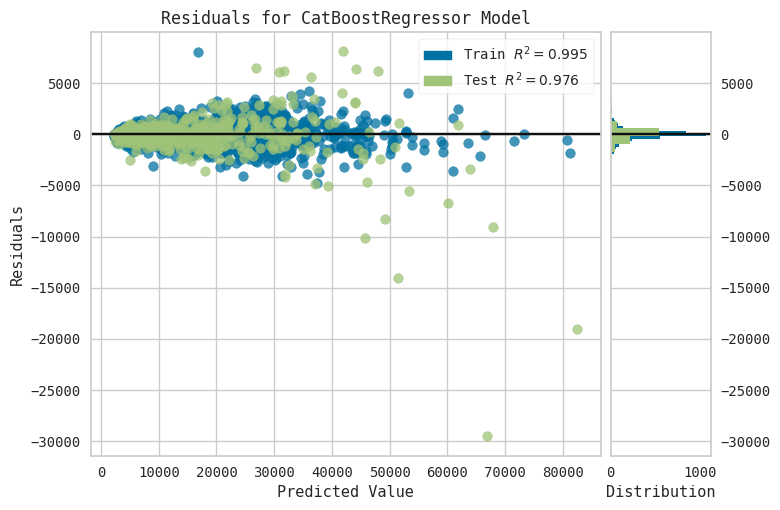

In [41]:
plot_model(best)

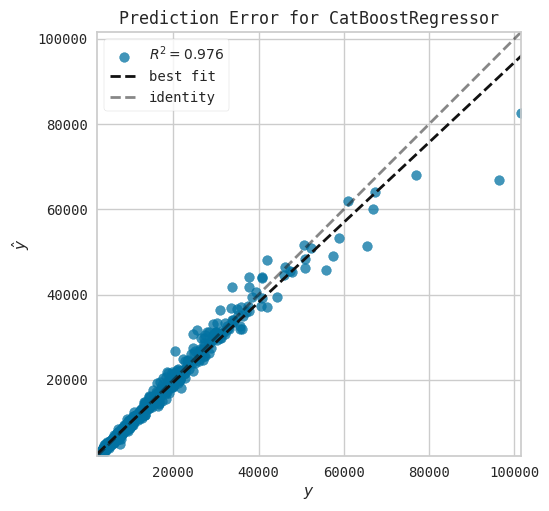

In [42]:
plot_model(best, plot = 'error')

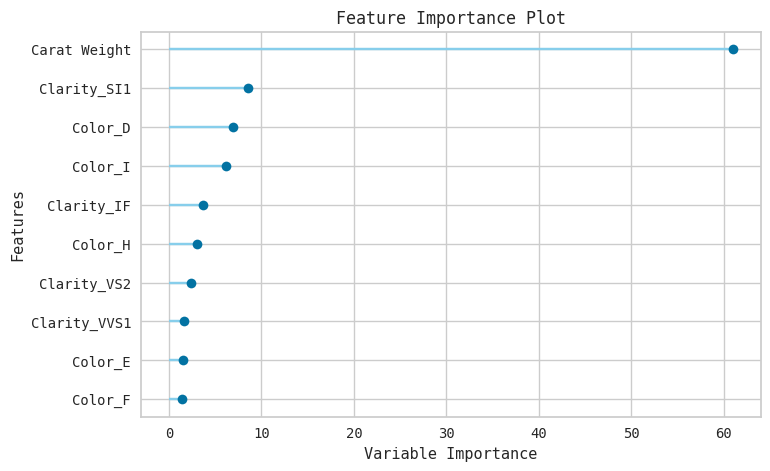

In [43]:
plot_model(best, plot='feature')

# Finalizando o Modelo

In [44]:
final_best = finalize_model(best)

# Salvando o Modelo

In [48]:
save_model(final_best, '../models_pkl/catboost_regressor')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='Price',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Price')),
                 ('fix_perfect', Remove_100(target='Price')),
                 ('clean_names', Clean_Colum_Names()),
                 ('

# Carregando o Modelo Salvo

In [50]:
model = load_model('../models_pkl/catboost_regressor')

Transformation Pipeline and Model Successfully Loaded


# Realizando Previsões

In [53]:
new_predictions = predict_model(model, data=df_prod)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,550.8134,1190255.5692,1090.9883,0.9888,0.0613,0.0458


In [54]:
from pycaret.utils import check_metric

check_metric(new_predictions['Price'], new_predictions['Label'], 'R2')

0.9888

In [55]:
check_metric(new_predictions['Price'], new_predictions['Label'], 'RMSE')

1090.9883

# Exercícios

## Utilizando o Pycaret + fastapi, crie uma API para consultar o modelo

## Utilizando o Pycaret + gradio, crie um web app para consultar o modelo

## Faça um `tune_model` do melhor modelo